In [ ]:
pip install pmdarima

In [ ]:
pip install dask[dataframe]

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings("ignore") # suppressing warnings

# Data Understanding: EDA

##Basic exploring

In [ ]:
df = pd.read_csv('train.csv')
df.head(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
5,6,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600
6,7,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800
7,8,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520
8,9,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040
9,10,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000


In [ ]:
df["Order Date"]

,Order Date
0,08/11/2017
1,08/11/2017
2,12/06/2017
3,11/10/2016
4,11/10/2016
...,...
9795,21/05/2017
9796,12/01/2016
9797,12/01/2016
9798,12/01/2016


In [ ]:
# checking how many rows and columns in the dataset
df.shape

(9800, 18)

In [ ]:
# getting more information from the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [ ]:
df.describe(include='all')

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
count,9800.000000,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9789.000000,9800,9800,9800,9800,9800,9800.000000
unique,NaN,4922,1230,1326,4,793,793,3,1,529,49,NaN,4,1861,3,17,1849,NaN
top,NaN,CA-2018-100111,05/09/2017,26/09/2018,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN
freq,NaN,14,38,34,5859,35,35,5101,9800,891,1946,NaN,3140,19,5909,1492,47,NaN
mean,4900.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55273.322403,NaN,NaN,NaN,NaN,NaN,230.769059
std,2829.160653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32041.223413,NaN,NaN,NaN,NaN,NaN,626.651875
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000
25%,2450.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223.000000,NaN,NaN,NaN,NaN,NaN,17.248000
50%,4900.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58103.000000,NaN,NaN,NaN,NaN,NaN,54.490000
75%,7350.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90008.000000,NaN,NaN,NaN,NaN,NaN,210.605000


In [ ]:
print(df['Category'].value_counts())
#print(df['Sub-Category'].value_counts())

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64


## Check for Missing Values

In [ ]:
missing_values = df.isnull().sum()
missing_values

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


##Check for Outliers

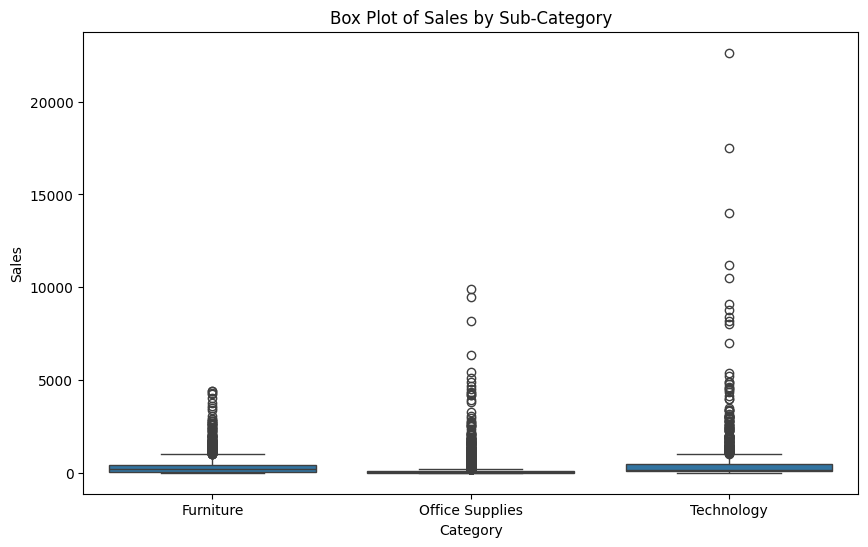

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Sales', data=df)
plt.title('Box Plot of Sales by Sub-Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.show()

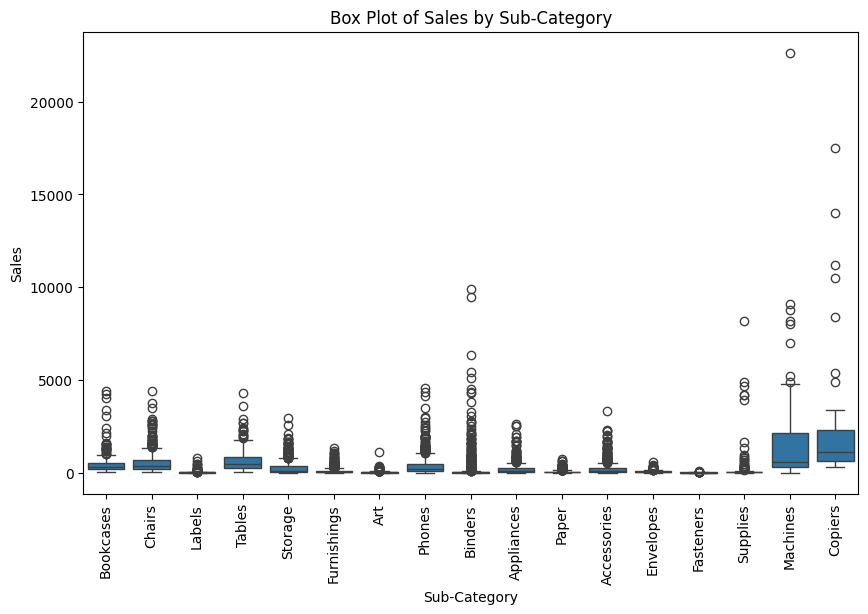

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sub-Category', y='Sales', data=df)
plt.title('Box Plot of Sales by Sub-Category')
plt.xlabel('Sub-Category')
plt.ylabel('Sales')
plt.xticks(rotation=90)
plt.show()

##Basic Analytic

###Customer Segmentation Analysis

In [ ]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales'],
      dtype='object')

In [ ]:
features = df[['Segment','Country','City','State','Sales']]
top_10_sales = features.nlargest(10, 'Sales')
print('Top 10 Sales Revenue')
print(top_10_sales[['Segment','Country','City','State','Sales']])

Top 10 Sales Revenue
          Segment        Country           City         State      Sales
2697  Home Office  United States   Jacksonville       Florida  22638.480
6826    Corporate  United States      Lafayette       Indiana  17499.950
8153     Consumer  United States        Seattle    Washington  13999.960
2623  Home Office  United States  New York City      New York  11199.968
4190     Consumer  United States         Newark      Delaware  10499.970
9039     Consumer  United States        Detroit      Michigan   9892.740
4098     Consumer  United States    Minneapolis     Minnesota   9449.950
4277    Corporate  United States       Lakewood    New Jersey   9099.930
8488     Consumer  United States      Arlington      Virginia   8749.950
6425     Consumer  United States   Philadelphia  Pennsylvania   8399.976


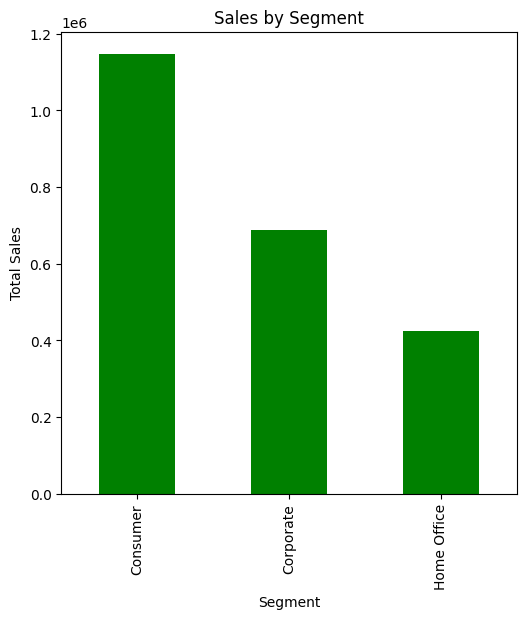

In [ ]:
segment_sales = df.groupby('Segment')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.subplot(1,3,1)
segment_sales.plot(kind='bar',color='green')
plt.title('Sales by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Sales')
plt.show()

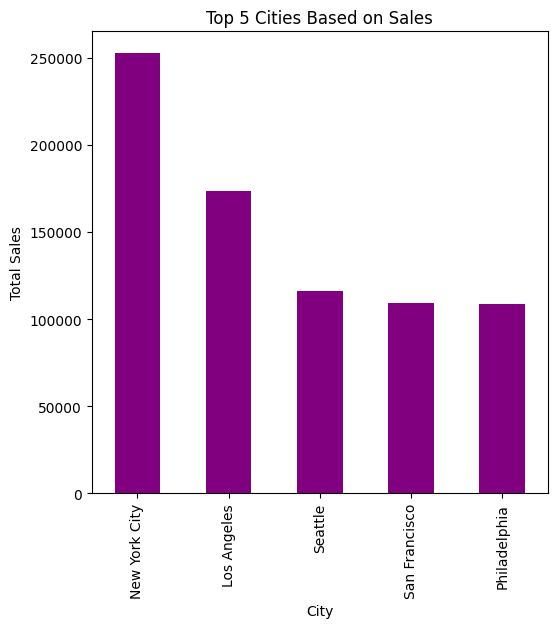

In [ ]:
segment_sales = df.groupby('City')['Sales'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(20,6))
plt.subplot(1,3,2)
segment_sales.plot(kind='bar',color='purple')
plt.title('Top 5 Cities Based on Sales')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.show()

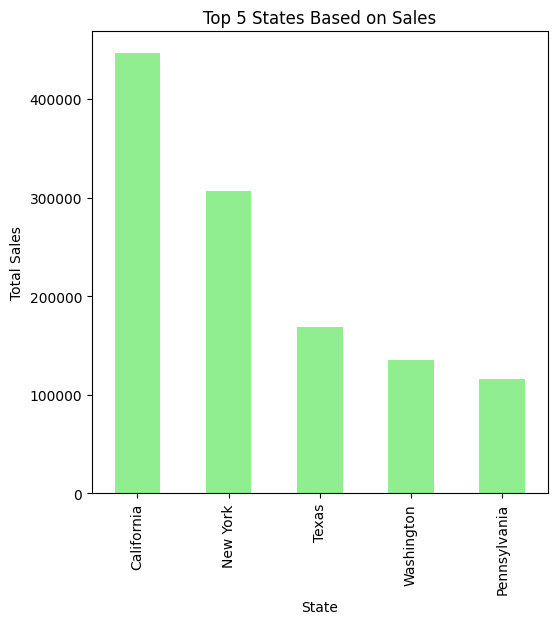

In [ ]:
segment_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(20,6))
plt.subplot(1,3,3)
segment_sales.plot(kind='bar',color='lightgreen')
plt.title('Top 5 States Based on Sales')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

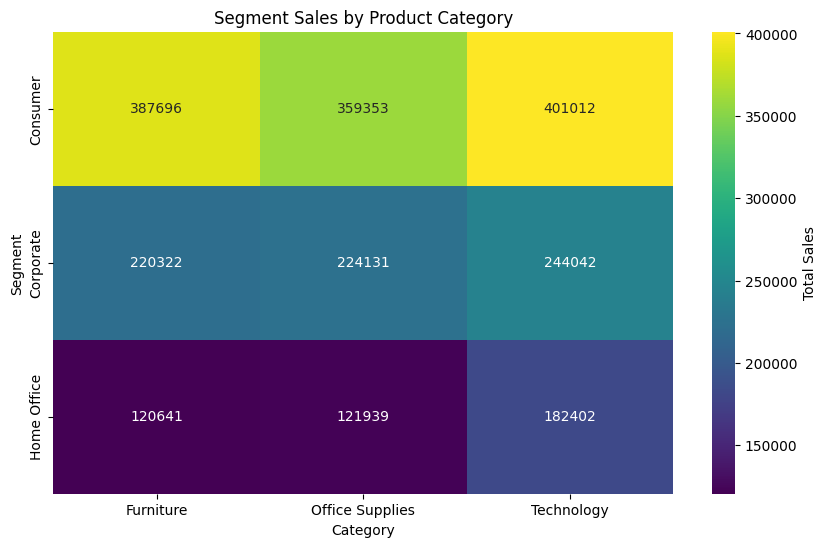

In [ ]:
heatmap_data = df.pivot_table(index='Segment', columns='Category', values='Sales', aggfunc='sum')
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.0f', cbar_kws={'label':'Total Sales'})
plt.title("Segment Sales by Product Category")
plt.show()

###Analyzing Order Fulfilment Efficiency

In [ ]:
# converting into datetime object
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')
df['Processing Time'] = (df['Ship Date']- df['Order Date']).dt.days
median_processing_time =df.groupby('Sub-Category')['Processing Time'].median().sort_values()
print('Median Processing Time for each Product Sub-Category (days)')
print(median_processing_time)

Median Processing Time for each Product Sub-Category (days)
Sub-Category
Accessories    4.0
Storage        4.0
Phones         4.0
Paper          4.0
Machines       4.0
Labels         4.0
Furnishings    4.0
Supplies       4.0
Fasteners      4.0
Copiers        4.0
Chairs         4.0
Bookcases      4.0
Binders        4.0
Art            4.0
Appliances     4.0
Envelopes      4.0
Tables         4.0
Name: Processing Time, dtype: float64


###Analyzing Sales Performance Trend

In [ ]:
# converting into datetime format
df['Order Date']= pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year

In [ ]:
highest_selling_product = df.groupby(['Year', 'Category', 'Sub-Category'])['Sales'].sum().reset_index()

# Find the index of the row with the highest sales in each year
idx = highest_selling_product.groupby('Year')['Sales'].idxmax()

# Select the corresponding rows
highest_selling_product = highest_selling_product.loc[idx]

print('Best Performance Product Category and Sub Category for Each Year')
print(highest_selling_product[['Year', 'Category', 'Sub-Category', 'Sales']])

Best Performance Product Category and Sub Category for Each Year
    Year    Category Sub-Category       Sales
16  2015  Technology       Phones   77225.956
18  2016   Furniture       Chairs   70654.673
35  2017   Furniture       Chairs   81930.345
67  2018  Technology       Phones  104685.658


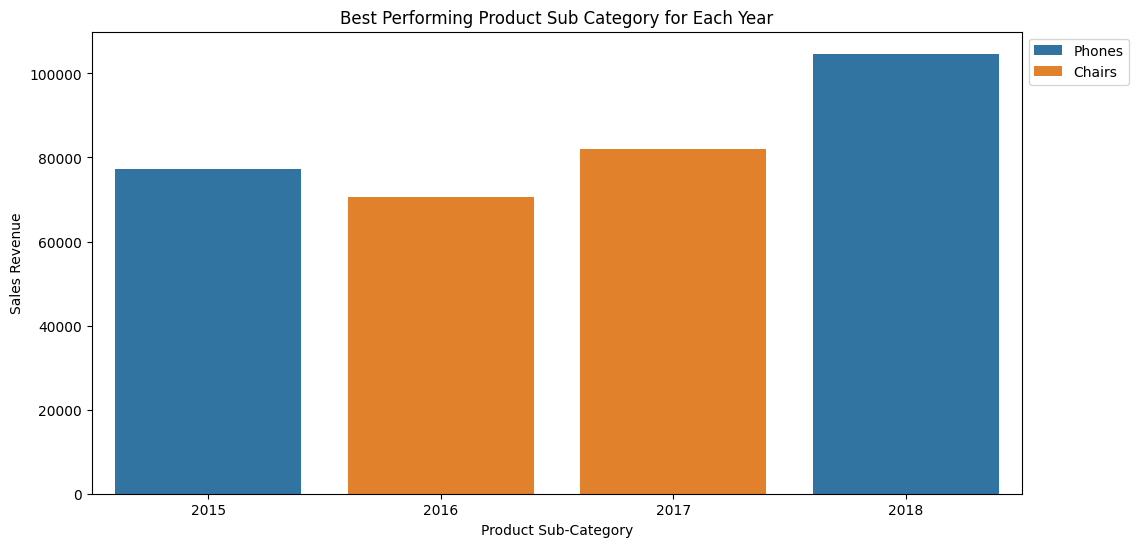

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Sales', hue='Sub-Category', data=highest_selling_product)
plt.title('Best Performing Product Sub Category for Each Year')
plt.xlabel('Product Sub-Category')
plt.ylabel('Sales Revenue')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

##Main Analytic


###Analysis of Sales Performance by Category Across Different Years

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Processing Time,Year
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,3,2017
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,2017
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,4,2017
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,7,2016
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,7,2016


In [ ]:
df.columns.tolist()

['Row ID',
 'Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales',
 'Processing Time',
 'Year']

In [ ]:
df['Year'].value_counts()

,count
Year,
2018,3258
2017,2534
2016,2055
2015,1953


In [ ]:
# Sales of each category of each years
category_sales_by_year = df.groupby(['Year', 'Category'])['Sales'].sum().reset_index()
print(category_sales_by_year)

    Year         Category        Sales
0   2015        Furniture  156477.8811
1   2015  Office Supplies  149512.8200
2   2015       Technology  173865.5070
3   2016        Furniture  164053.8674
4   2016  Office Supplies  133124.4070
5   2016       Technology  162257.7310
6   2017        Furniture  195813.0400
7   2017  Office Supplies  182417.5660
8   2017       Technology  221961.9440
9   2018        Furniture  212313.7872
10  2018  Office Supplies  240367.5410
11  2018       Technology  269370.6910


In [ ]:
category_sales_by_year = df.pivot_table(index='Year', columns='Category', values='Sales', aggfunc='sum').reset_index()

# Remove the "Category" name from the columns
category_sales_by_year.columns.name = None

print(category_sales_by_year)

   Year    Furniture  Office Supplies  Technology
0  2015  156477.8811       149512.820  173865.507
1  2016  164053.8674       133124.407  162257.731
2  2017  195813.0400       182417.566  221961.944
3  2018  212313.7872       240367.541  269370.691


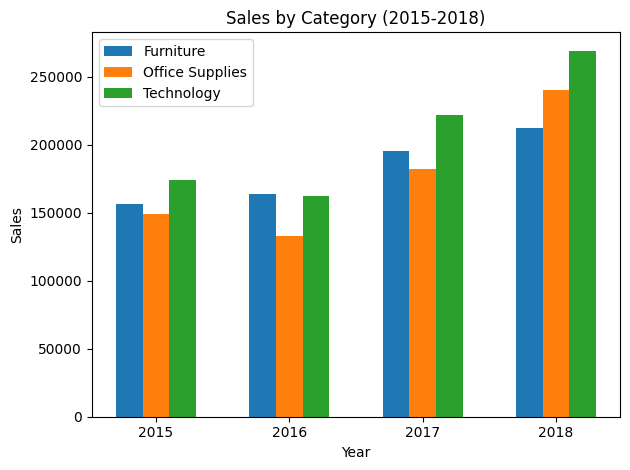

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
x = np.arange(len(category_sales_by_year['Year']))

# Create the bar plot
plt.bar(x - bar_width, category_sales_by_year['Furniture'], width=bar_width, label='Furniture', align='center')
plt.bar(x, category_sales_by_year['Office Supplies'], width=bar_width, label='Office Supplies', align='center')
plt.bar(x + bar_width, category_sales_by_year['Technology'], width=bar_width, label='Technology', align='center')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales by Category (2015-2018)')
plt.xticks(x, category_sales_by_year['Year'])  # Set the x-ticks to the years
plt.legend()  # Show the legend

# Show the plot
plt.tight_layout()
plt.show()


#Preprocessing

## Cleaning Dataset by Removing Missing Values & Duplicates

In [ ]:
print(df.isnull().sum().sort_values(ascending=False))

Postal Code        11
Row ID              0
Order ID            0
Processing Time     0
Sales               0
Product Name        0
Sub-Category        0
Category            0
Product ID          0
Region              0
State               0
City                0
Country             0
Segment             0
Customer Name       0
Customer ID         0
Ship Mode           0
Ship Date           0
Order Date          0
Year                0
dtype: int64


In [ ]:
df.duplicated().any() # check if any duplicates exist in the dataframe

False

In [ ]:
#delete column postal code
print("Before deleting the column", df.columns.tolist())
df.drop('Postal Code', axis=1, inplace=True)
print("After deleting the column", df.columns.tolist())

Before deleting the column ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Processing Time', 'Year']
After deleting the column ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Processing Time', 'Year']


##Date Format Changing

In [ ]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format='%d/%m/%Y')
sorted_date = df["Order Date"].sort_values()
print(sorted_date)

7980   2015-01-03
741    2015-01-04
740    2015-01-04
739    2015-01-04
1759   2015-01-05
          ...    
1297   2018-12-30
906    2018-12-30
645    2018-12-30
908    2018-12-30
5091   2018-12-30
Name: Order Date, Length: 9800, dtype: datetime64[ns]


In [ ]:
df["Order Date"]

,Order Date
0,2017-11-08
1,2017-11-08
2,2017-06-12
3,2016-10-11
4,2016-10-11
...,...
9795,2017-05-21
9796,2016-01-12
9797,2016-01-12
9798,2016-01-12


##Grouping the data

In [ ]:
# Grouping the data and resetting the index
sales_by_category = df.groupby(["Category", df["Order Date"].dt.year])["Sales"].sum().reset_index()
print(sales_by_category)

           Category  Order Date        Sales
0         Furniture        2015  156477.8811
1         Furniture        2016  164053.8674
2         Furniture        2017  195813.0400
3         Furniture        2018  212313.7872
4   Office Supplies        2015  149512.8200
5   Office Supplies        2016  133124.4070
6   Office Supplies        2017  182417.5660
7   Office Supplies        2018  240367.5410
8        Technology        2015  173865.5070
9        Technology        2016  162257.7310
10       Technology        2017  221961.9440
11       Technology        2018  269370.6910


##Spliting

Do in Model section

#2018 Sales Forecast

##Model + Model Evaluation

In [ ]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Define a function to forecast sales for each category using ARIMA
def forecast_sales(category_data):
    # Set 'Order Date' as index and get the sales data
    sales_series = category_data.set_index("Order Date")["Sales"]

    # Split the data into training and validation sets with 80% training and 20% validation
    train_data, valid_data = train_test_split(sales_series, test_size=0.2, shuffle=False)

    # Fit the ARIMA model on the training data
    model = auto_arima(train_data, seasonal=True, suppress_warnings=True, stepwise=True)

    # Forecast for the validation period
    forecast_valid = model.predict(n_periods=len(valid_data))

    # Calculate MAE on the validation set
    mae = mean_absolute_error(valid_data, forecast_valid)

    # Now forecast for 2018 (1 period ahead)
    forecast_2018 = model.predict(n_periods=1)

    return pd.Series({
        "Category": category_data["Category"].iloc[0],
        "Forecasted_Sales_2018": forecast_2018.sum(),
        "MAE": mae
    })

# Apply the forecast_sales function to each category
forecasted_sales = sales_by_category.groupby("Category").apply(forecast_sales).reset_index(drop=True)

# Formatting the Forecasted_Sales_2018 column
forecasted_sales["Forecasted_Sales_2018"] = forecasted_sales["Forecasted_Sales_2018"].apply(lambda x: '{:,.2f}'.format(x))

# Displaying the result
print("Forecasted Sales in 2018 for Each Product Category:")
print(forecasted_sales[["Category", "Forecasted_Sales_2018", "MAE"]])

Forecasted Sales in 2018 for Each Product Category:
          Category Forecasted_Sales_2018           MAE
0        Furniture            172,114.93  40198.857700
1  Office Supplies            155,018.26  85349.276667
2       Technology            186,028.39  83342.297000


#2019 Sales Forecast

In [ ]:
from pmdarima import auto_arima
sales_by_category = df.groupby(["Category", df["Order Date"].dt.year])["Sales"].sum().reset_index()

# Define a function to forecast sales for each category
def forecast_sales(category_data):
    sales_series = category_data.set_index("Order Date")["Sales"]
    model = auto_arima(sales_series, seasonal=True, suppress_warnings=True, stepwise=True)
    forecast = model.predict(n_periods=1)
    return pd.Series({
        "Category": category_data["Category"].iloc[0],
        "Forecasted_Sales_2019": forecast.sum()
    })

# Applying the forecast_sales function to each category group
forecasted_sales = sales_by_category.groupby("Category").apply(forecast_sales).reset_index(drop=True)

# Formatting the Forecasted_Sales_2019 column
forecasted_sales["Forecasted_Sales_2019"] = forecasted_sales["Forecasted_Sales_2019"].apply(lambda x: '{:,.2f}'.format(x))

# Displaying the result
print("Forecasted Sales in 2019 for Each Product Category:")
print(forecasted_sales[["Category", "Forecasted_Sales_2019"]])

Forecasted Sales in 2019 for Each Product Category:
          Category Forecasted_Sales_2019
0        Furniture            182,164.64
1  Office Supplies            176,355.58
2       Technology            206,863.97


# Q&A


In [ ]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR

# 1. Univariate Forecasting (Existing Code)
def forecast_sales(category_data):
    sales_series = category_data.set_index("Order Date")["Sales"]
    train_data, valid_data = train_test_split(sales_series, test_size=0.2, shuffle=False)
    model = auto_arima(train_data, seasonal=True, suppress_warnings=True, stepwise=True)
    forecast_valid = model.predict(n_periods=len(valid_data))
    mae = mean_absolute_error(valid_data, forecast_valid)
    forecast_2018 = model.predict(n_periods=1)
    return pd.Series({
        "Category": category_data["Category"].iloc[0],
        "Forecasted_Sales_2018": forecast_2018.sum(),
        "MAE": mae
    })

sales_by_category = df.groupby(["Category", df["Order Date"].dt.year])["Sales"].sum().reset_index()
forecasted_sales_uni = sales_by_category.groupby("Category").apply(forecast_sales).reset_index(drop=True)
print("Forecasted Sales in 2018 for Each Product Category (Univariate):")
print(forecasted_sales_uni[["Category", "Forecasted_Sales_2018", "MAE"]])

# 2. Multivariate Forecasting
sales_by_category = df.groupby(["Category", df["Order Date"].dt.year])["Sales"].sum().reset_index()
sales_pivot = sales_by_category.pivot_table(index='Order Date', columns='Category', values='Sales', aggfunc='sum').reset_index()
# Convert 'Order Date' to datetime if not already
sales_pivot['Order Date'] = pd.to_datetime(sales_pivot['Order Date'])
sales_pivot.set_index('Order Date', inplace=True)

train_data, valid_data = train_test_split(sales_pivot, test_size=0.2, shuffle=False)

model = VAR(train_data[['Furniture', 'Office Supplies', 'Technology']])
model_fit = model.fit()

forecast_valid = model_fit.forecast(valid_data[['Furniture', 'Office Supplies', 'Technology']].values, steps=len(valid_data))

mae_furniture = mean_absolute_error(valid_data['Furniture'], forecast_valid[:, 0])
mae_office_supplies = mean_absolute_error(valid_data['Office Supplies'], forecast_valid[:, 1])
mae_technology = mean_absolute_error(valid_data['Technology'], forecast_valid[:, 2])

# Forecast for 2018 (1 period ahead)
forecast_2018 = model_fit.forecast(model.endog[-1:], steps=1)  # Using model.endog

print("\nForecasted Sales in 2018 for Each Product Category (Multivariate):")
print(f"Furniture: {forecast_2018[0][0]:,.2f}")
print(f"Office Supplies: {forecast_2018[0][1]:,.2f}")
print(f"Technology: {forecast_2018[0][2]:,.2f}")

print("\nMAE for Each Category (Multivariate):")
print(f"Furniture: {mae_furniture:.2f}")
print(f"Office Supplies: {mae_office_supplies:.2f}")
print(f"Technology: {mae_technology:.2f}")

Forecasted Sales in 2018 for Each Product Category (Univariate):
          Category  Forecasted_Sales_2018           MAE
0        Furniture          172114.929500  40198.857700
1  Office Supplies          155018.264333  85349.276667
2       Technology          186028.394000  83342.297000

Forecasted Sales in 2018 for Each Product Category (Multivariate):
Furniture: 208,863.50
Office Supplies: 171,570.85
Technology: 209,084.54

MAE for Each Category (Multivariate):
Furniture: 27755.43
Office Supplies: 128457.68
Technology: 132364.42


In [ ]:
# Full code combining all the steps for predicting next year's sales and calculating MAE

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Load the data
data = pd.read_csv('train.csv')

# Convert 'Order Date' to datetime and sort the data
data['Order Date'] = pd.to_datetime(data['Order Date'], format="%d/%m/%Y")
data = data.sort_values('Order Date')

# Summarize sales per year and per category
data['Year'] = data['Order Date'].dt.year
yearly_sales = data.groupby(['Year', 'Category'])['Sales'].sum().reset_index()

# Predict next year sales and calculate MAE for each category
next_year_predictions = {}
category_mae_next_year = {}

for category in yearly_sales['Category'].unique():
    # Filter data for the specific category
    category_data = yearly_sales[yearly_sales['Category'] == category]

    # Prepare features and target (previous year sales and current year sales)
    category_data['Previous_Sales'] = category_data['Sales'].shift(1)
    category_data = category_data.dropna(subset=['Previous_Sales'])

    X_cat = category_data[['Previous_Sales']]
    y_cat = category_data['Sales']

    # Train a linear regression model
    model_cat = LinearRegression()
    model_cat.fit(X_cat, y_cat)

    # Use the last year's sales to predict the next year's sales
    last_year_sales = category_data['Sales'].values[-1]
    next_year_sales = model_cat.predict([[last_year_sales]])

    # Store the prediction
    next_year_predictions[category] = next_year_sales[0]

    # Predict for all data to calculate MAE
    y_pred_cat = model_cat.predict(X_cat)

    # Calculate MAE for the predictions
    category_mae_next_year[category] = mean_absolute_error(y_cat, y_pred_cat)

# Create DataFrames for the yearly sales, predictions, and MAE
next_year_sales_df = pd.DataFrame({
    'Category': next_year_predictions.keys(),
    'Predicted Sales for Next Year': next_year_predictions.values()
})

mae_df = pd.DataFrame({
    'Category': category_mae_next_year.keys(),
    'MAE': category_mae_next_year.values()
})

# Display the yearly sales and predictions
yearly_sales_pivot = yearly_sales.pivot(index='Year', columns='Category', values='Sales')
# Printing the results for the user

print("Yearly Sales by Category:")
print(yearly_sales_pivot)

print("\nNext Year Sales Predictions:")
print(next_year_sales_df)

print("\nMAE for Next Year Sales Predictions:")
print(mae_df)



Yearly Sales by Category:
Category    Furniture  Office Supplies  Technology
Year                                              
2015      156477.8811       149512.820  173865.507
2016      164053.8674       133124.407  162257.731
2017      195813.0400       182417.566  221961.944
2018      212313.7872       240367.541  269370.691

Next Year Sales Predictions:
          Category  Predicted Sales for Next Year
0        Furniture                  231689.854135
1  Office Supplies                  311201.477018
2       Technology                  318901.326638

MAE for Next Year Sales Predictions:
          Category           MAE
0        Furniture   8866.952158
1  Office Supplies  29371.806663
2       Technology  27240.242578
